# Import Packages

In [0]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn as sns
import imblearn
import random
import missingno as msno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Description
*   loan_number = id
*   amount_borrowed = initial amoount borrowed
*   borrower_rate = int_rate
*   prosper_rating = grade
*   term = time
*   age_in_months = from originial data to current date 2020
*   origination date
*   days_past_due = comes after
*   principal_balance = amount left he has to pay form og amount
*   service_fees_paid = amount to process loans
*   prosper fees = subs

# Did not use
* loan_number
* late_fees
* age_in_months
* days_past_due
* origination date
* principal_balance
* principal_paid
* interest_paid
* late_fees_paid
* debt_sale_proceeds_received
* loan_default_reason
* loan_default_reason_description
* next_payment_due_date
* next_payment_due_amount
* co_borrower_application


#things to construct
* recoveries
* total payment
* actual length of the loan =  next_payment_due_date - origin

# Load Data

In [0]:
df_2013 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2013.csv')
df_2014 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2014.csv')
df_2015 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2015.csv')
df_2016 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2016.csv')
df_2017 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2017.csv')
df_2018 = pd.read_csv('/content/drive/My Drive/ServiceAnalytics/Data/2018.csv')

df = pd.concat([df_2013,df_2014,df_2015,df_2016,df_2017,df_2018]) 
df_backup = df


In [0]:
df.describe()

,loan_number,amount_borrowed,borrower_rate,term,age_in_months,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,prosper_fees_paid,late_fees_paid,debt_sale_proceeds_received,loan_status,loan_default_reason,next_payment_due_amount
count,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1.000567e+06,1000567.0,1.000567e+06,109172.000000,1.000567e+06
mean,6.292407e+05,1.333343e+04,1.529735e-01,4.308733e+01,4.624328e+01,3.683006e+01,1.955992e+03,-1.878433e+02,1.053186e+04,2.617268e+03,3.440836e+00,8.578875e+00,0.0,3.193950e+00,6.088209,1.252879e+02
std,3.129995e+05,7.985182e+03,6.580734e-02,1.096262e+01,1.714340e+01,1.621215e+02,4.411464e+03,1.582090e+02,7.833725e+03,2.406324e+03,1.440803e+01,4.642298e+01,0.0,1.195200e+00,1.806341,2.239193e+02
min,7.965000e+04,2.000000e+03,5.310000e-02,1.200000e+01,1.700000e+01,0.000000e+00,0.000000e+00,-1.860430e+03,-1.500000e+01,-8.255100e+00,0.000000e+00,0.000000e+00,0.0,1.000000e+00,2.000000,-3.988900e+02
25%,3.536995e+05,7.500000e+03,1.030000e-01,3.600000e+01,3.100000e+01,0.000000e+00,0.000000e+00,-2.539400e+02,4.400000e+03,9.508550e+02,0.000000e+00,0.000000e+00,0.0,2.000000e+00,6.000000,0.000000e+00
50%,6.426190e+05,1.200000e+04,1.375000e-01,3.600000e+01,4.900000e+01,0.000000e+00,0.000000e+00,-1.465400e+02,9.000000e+03,1.882680e+03,0.000000e+00,0.000000e+00,0.0,4.000000e+00,7.000000,0.000000e+00
75%,8.976775e+05,1.800000e+04,1.920000e-01,6.000000e+01,5.900000e+01,0.000000e+00,1.147735e+03,-7.191000e+01,1.500000e+04,3.515725e+03,0.000000e+00,0.000000e+00,0.0,4.000000e+00,7.000000,1.962900e+02
max,1.180599e+06,4.000000e+04,3.192000e-01,6.000000e+01,8.800000e+01,2.417000e+03,4.000000e+04,4.700000e+00,4.000000e+04,2.190201e+04,8.700000e+02,1.706860e+03,0.0,6.000000e+00,7.000000,1.959478e+04


# Data PreProcessing

## Select Rows with only completed

In [0]:
df = df[df["loan_status_description"].isin(['COMPLETED','DEFAULTED', 'CHARGEDOFF', 'CANCELLED'])]

df["loan_status_description"] = np.where(df["loan_status_description"] == 'COMPLETED',0,1)

df = df[df["term"] >= 36]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df

,loan_number,amount_borrowed,borrower_rate,prosper_rating,term,age_in_months,origination_date,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,prosper_fees_paid,late_fees_paid,debt_sale_proceeds_received,loan_status,loan_status_description,loan_default_reason,loan_default_reason_description,next_payment_due_date,next_payment_due_amount,co_borrower_application
1,79656,4000.0,0.1559,B,36,88,2013-01-02 00:00:00,0,0.0,-51.84,4000.0,808.28,0.0,0.00,0.0,4,0,NaN,NaN,2015-04-02 00:00:00,0.00,False
2,79665,17500.0,0.2398,C,60,88,2013-01-02 00:00:00,0,0.0,-66.89,17500.0,1604.20,0.0,0.00,0.0,4,0,NaN,NaN,2015-04-02 00:00:00,0.00,False
3,79659,15000.0,0.1564,A,60,88,2013-01-02 00:00:00,0,0.0,-298.07,15000.0,4661.84,0.0,0.00,0.0,4,0,NaN,NaN,2016-08-02 00:00:00,361.91,False
4,79668,10000.0,0.2118,C,60,88,2013-01-02 00:00:00,0,0.0,-235.48,10000.0,4987.94,0.0,0.00,0.0,4,0,NaN,NaN,2016-08-02 00:00:00,271.55,False
5,79662,9500.0,0.1939,C,36,88,2013-01-02 00:00:00,0,0.0,-98.53,9500.0,1910.21,15.0,35.02,0.0,4,0,NaN,NaN,2015-04-02 00:00:00,0.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198746,1167680,10500.0,0.1628,C,60,17,2018-12-31 00:00:00,0,0.0,-42.70,10500.0,646.63,0.0,0.00,0.0,4,0,NaN,NaN,2019-06-30 00:00:00,0.00,False
198748,1171231,9500.0,0.1003,A,36,17,2018-12-31 00:00:00,0,0.0,-76.21,9500.0,711.10,15.0,0.00,0.0,4,0,NaN,NaN,2019-11-30 00:00:00,0.00,False
198750,1167848,7000.0,0.0904,A,36,17,2018-12-31 00:00:00,0,0.0,-69.31,7000.0,582.61,0.0,0.00,0.0,4,0,NaN,NaN,2020-02-11 00:00:00,0.00,False
198751,1180476,8500.0,0.2204,C,36,17,2018-12-31 00:00:00,0,0.0,-42.17,8500.0,864.68,0.0,0.00,0.0,4,0,NaN,NaN,2019-07-03 00:00:00,0.00,False


## Remove Null Values

In [0]:
df = df.drop(['loan_status','loan_default_reason','loan_default_reason_description'],axis=1)

In [0]:
df = df.dropna()

# Create Required Columns

## Total Payment

In [0]:
df['total_pymnt'] = df['principal_paid'] + df['interest_paid']

## Recoveries

In [0]:
df['recoveries'] = df['principal_paid']

## Actual Length of Loan

### Convert Start and End Date to DateTime

In [0]:
df['issue_d'] = pd.to_datetime(df['origination_date'], errors='coerce')
df['last_pymnt_d'] = pd.to_datetime(df['next_payment_due_date'], errors='coerce')
df = df.drop(['origination_date','next_payment_due_date'],axis=1)

### Ensure Closed Date is after issue_d or other than 0

In [0]:
df = df[df['last_pymnt_d']>df['issue_d']]

### Calculation

In [0]:
df['loan_length'] = (df.last_pymnt_d - df.issue_d) / np.timedelta64(1, 'M')
df['loan_length'] = df['loan_length'].astype(int)
df = df[df.loan_length != 0]

# Create Target Variable

Since we do not have a target variable that tells us if a loan had defaulted or not, we can get that information by looking if the next payment due is positive.

In [0]:
df['loan_status'] = df['loan_status_description']
df = df.drop(['loan_status_description'],axis=1)
df['grade'] = df['prosper_rating']
df = df.drop(['prosper_rating'],axis=1)

# Assign Columns to specific types

In [0]:
df

,loan_number,amount_borrowed,borrower_rate,term,age_in_months,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,prosper_fees_paid,late_fees_paid,debt_sale_proceeds_received,next_payment_due_amount,co_borrower_application,total_pymnt,recoveries,issue_d,last_pymnt_d,loan_length,loan_status,grade
1,79656,4000.0,0.1559,36,88,0,0.0,-51.84,4000.0,808.28,0.0,0.00,0.0,0.00,False,4808.28,4000.0,2013-01-02,2015-04-02,26,0,B
2,79665,17500.0,0.2398,60,88,0,0.0,-66.89,17500.0,1604.20,0.0,0.00,0.0,0.00,False,19104.20,17500.0,2013-01-02,2015-04-02,26,0,C
3,79659,15000.0,0.1564,60,88,0,0.0,-298.07,15000.0,4661.84,0.0,0.00,0.0,361.91,False,19661.84,15000.0,2013-01-02,2016-08-02,42,0,A
4,79668,10000.0,0.2118,60,88,0,0.0,-235.48,10000.0,4987.94,0.0,0.00,0.0,271.55,False,14987.94,10000.0,2013-01-02,2016-08-02,42,0,C
5,79662,9500.0,0.1939,36,88,0,0.0,-98.53,9500.0,1910.21,15.0,35.02,0.0,0.00,False,11410.21,9500.0,2013-01-02,2015-04-02,26,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198746,1167680,10500.0,0.1628,60,17,0,0.0,-42.70,10500.0,646.63,0.0,0.00,0.0,0.00,False,11146.63,10500.0,2018-12-31,2019-06-30,5,0,C
198748,1171231,9500.0,0.1003,36,17,0,0.0,-76.21,9500.0,711.10,15.0,0.00,0.0,0.00,False,10211.10,9500.0,2018-12-31,2019-11-30,10,0,A
198750,1167848,7000.0,0.0904,36,17,0,0.0,-69.31,7000.0,582.61,0.0,0.00,0.0,0.00,False,7582.61,7000.0,2018-12-31,2020-02-11,13,0,A
198751,1180476,8500.0,0.2204,36,17,0,0.0,-42.17,8500.0,864.68,0.0,0.00,0.0,0.00,False,9364.68,8500.0,2018-12-31,2019-07-03,6,0,C


# Assign Column Types

In [0]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = set(df.columns)
not_to_pick = ['loan_number','days_past_due', 'principal_paid','interest_paid','late_fees_paid','debt_sale_proceeds_received','next_payment_due_amount','age_in_months']
not_to_pick = set(not_to_pick)
cols_to_pick = list(cols_to_pick - not_to_pick)

# Identify the type of each of these column
float_cols = ['amount_borrowed','borrower_rate','term','service_fees_paid','prosper_fees_paid','total_pymnt','recoveries','loan_status']
cat_cols = ['term', 'co_borrower_application','grade']
date_cols = ['issue_d', 'last_pymnt_d']


#[i for i in date_cols if i in not_to_pick]

# Prepare Final Dataset

## Missing No Correlation

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


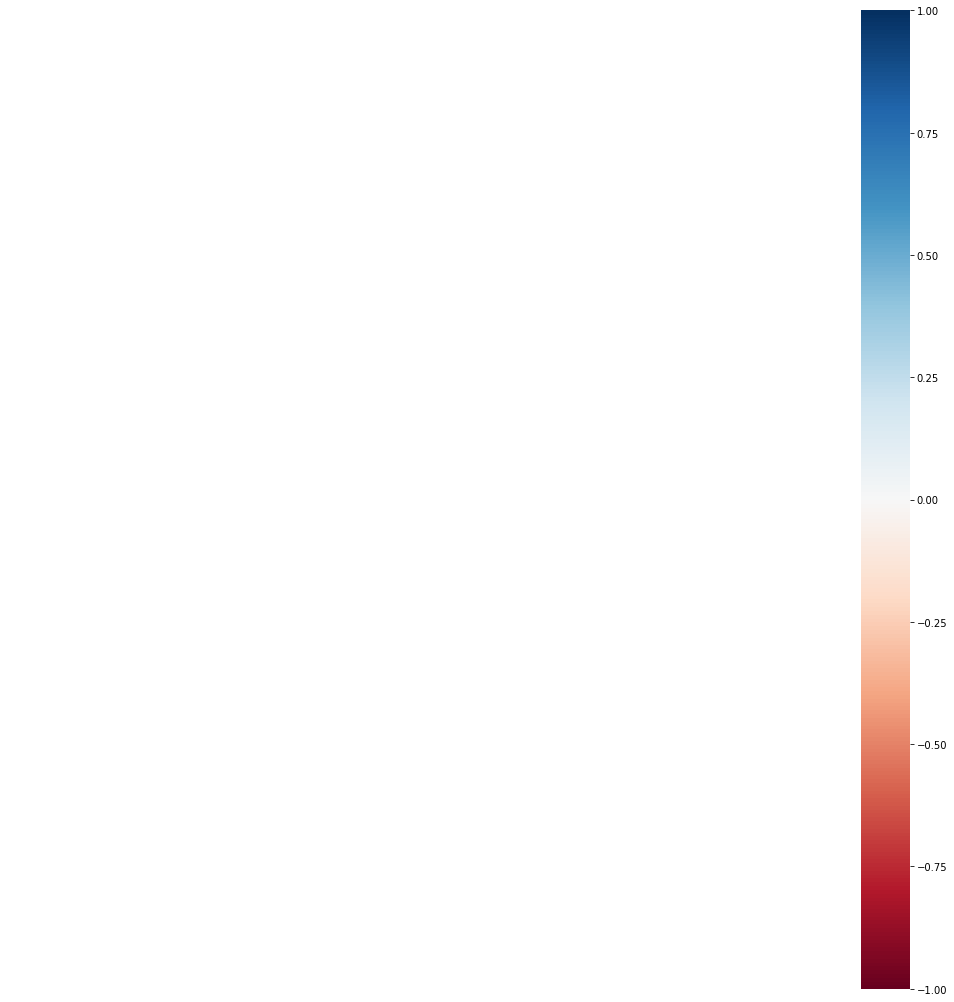

In [0]:
ax = msno.heatmap(df, figsize=(18, 18))

## Correlation

Check top 10 positive and negative correlations

In [0]:
corr = df.corr()['loan_status'].sort_values()

# Display correlations
print('Top 10 - Positive Correlations:')
print('-----------------------------------')
print(corr.tail(10))
print('\nTop 10 - Negative Correlations:')
print('------------------------------')
print(corr.head(10))

Top 10 - Positive Correlations:
-----------------------------------
term                           0.102811
service_fees_paid              0.104814
late_fees_paid                 0.105903
age_in_months                  0.115527
borrower_rate                  0.170636
principal_balance              0.307483
days_past_due                  0.326288
loan_status                    1.000000
debt_sale_proceeds_received         NaN
co_borrower_application             NaN
Name: loan_status, dtype: float64

Top 10 - Negative Correlations:
------------------------------
principal_paid            -0.388577
recoveries                -0.388577
total_pymnt               -0.339452
loan_number               -0.117796
loan_length               -0.078809
interest_paid             -0.036537
amount_borrowed            0.007077
prosper_fees_paid          0.076323
next_payment_due_amount    0.092813
term                       0.102811
Name: loan_status, dtype: float64


[Text(0.5, 0, 'loan_number'),
 Text(1.5, 0, 'amount_borrowed'),
 Text(2.5, 0, 'borrower_rate'),
 Text(3.5, 0, 'term'),
 Text(4.5, 0, 'age_in_months'),
 Text(5.5, 0, 'days_past_due'),
 Text(6.5, 0, 'principal_balance'),
 Text(7.5, 0, 'service_fees_paid'),
 Text(8.5, 0, 'principal_paid'),
 Text(9.5, 0, 'interest_paid'),
 Text(10.5, 0, 'prosper_fees_paid'),
 Text(11.5, 0, 'late_fees_paid'),
 Text(12.5, 0, 'debt_sale_proceeds_received'),
 Text(13.5, 0, 'next_payment_due_amount'),
 Text(14.5, 0, 'co_borrower_application'),
 Text(15.5, 0, 'total_pymnt'),
 Text(16.5, 0, 'recoveries'),
 Text(17.5, 0, 'loan_length'),
 Text(18.5, 0, 'loan_status')]

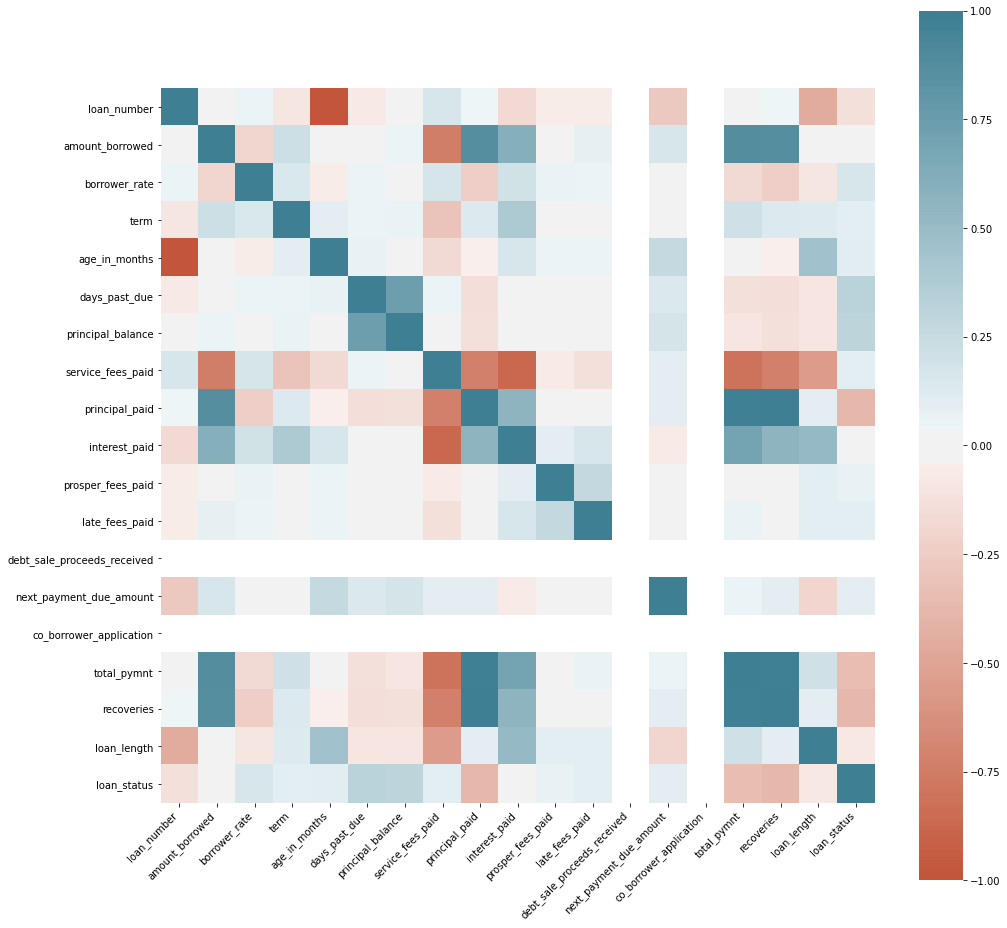

In [0]:
correlation = df.corr()
plt.figure(figsize=(16, 16))
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## Distribution of interest rate for default and non-defaults

Text(0.5, 1.0, 'Distribution of Interest Rate')

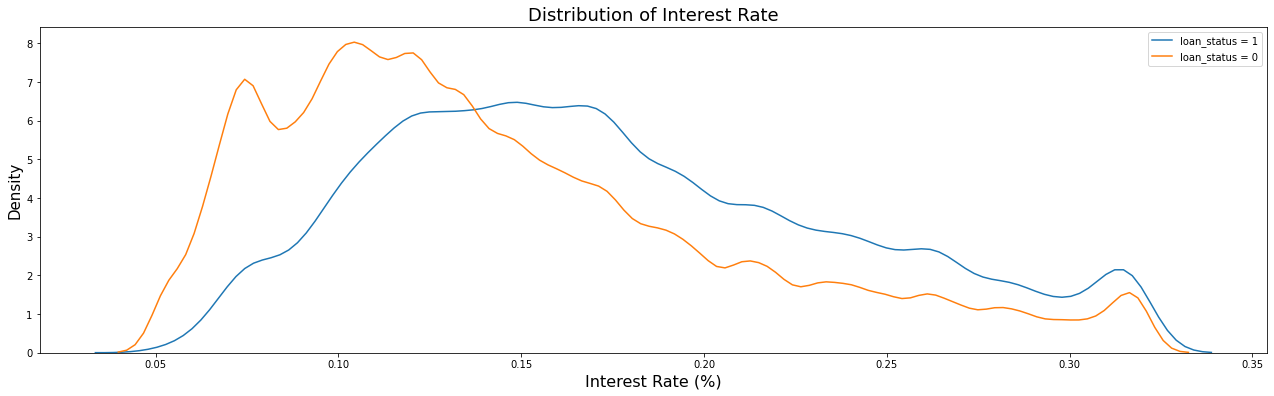

In [0]:
fig = plt.figure(figsize=(22, 6))
sns.kdeplot(df.loc[df['loan_status'] == 1, 'borrower_rate'], label='loan_status = 1')
sns.kdeplot(df.loc[df['loan_status'] == 0, 'borrower_rate'], label='loan_status = 0')
plt.xlabel('Interest Rate (%)', fontsize=16)
plt.ylabel('Density', fontsize=15)
plt.title('Distribution of Interest Rate', fontsize=18)

## Terms for different loan amounts

Text(0, 0.5, 'Loan Amount')

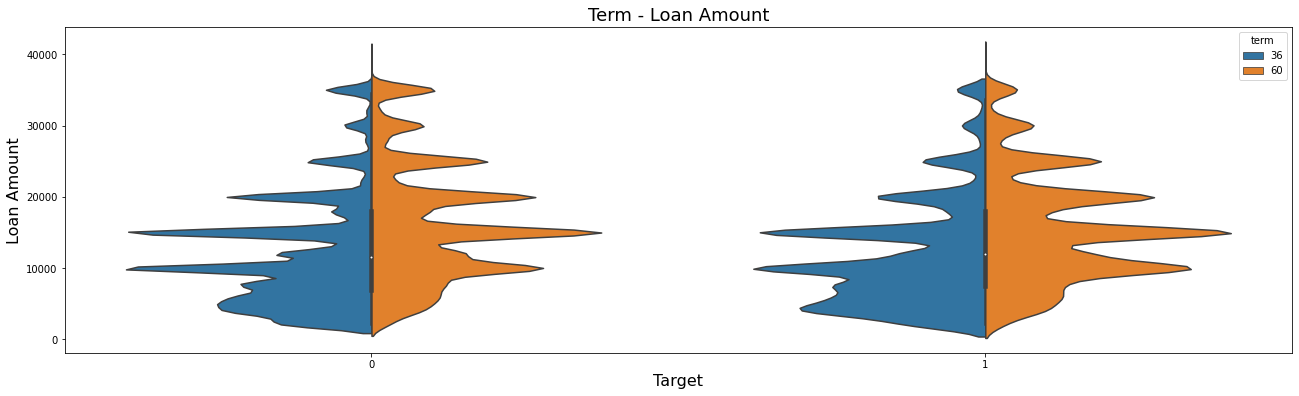

In [0]:
fig = plt.figure(figsize=(22, 6))
sns.violinplot(x="loan_status",
               y="amount_borrowed",
               data=df,
               hue="term",
               split=True,
               fontsize=16)

plt.title("Term - Loan Amount", fontsize=18)
plt.xlabel("Target", fontsize=16)
plt.ylabel("Loan Amount", fontsize=16)

## Lending Club assigned loan grades and interest rates

Text(0, 0.5, 'Interest Rate')

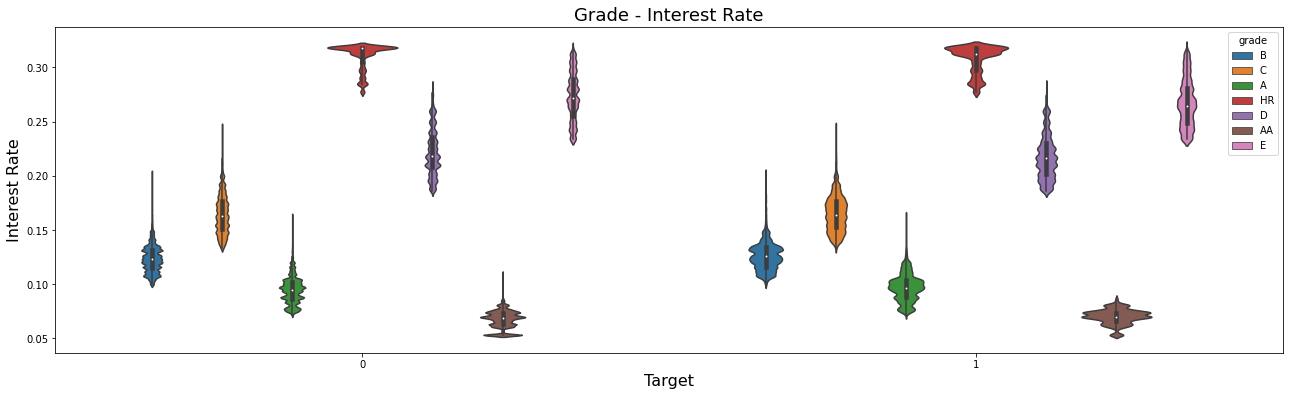

In [0]:
fig = plt.figure(figsize=(22, 6))
sns.violinplot(x="loan_status", y="borrower_rate", data=df, hue="grade", fontsize=16)
plt.title("Grade - Interest Rate", fontsize=18)
plt.xlabel("Target", fontsize=16)
plt.ylabel("Interest Rate", fontsize=16)

## TypeCast the Columns

In [0]:
for i in float_cols:
    df[i] = df[i].astype(float)
    
for i in cat_cols:
    df.loc[df[i].isnull(), i] = None

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735256 entries, 1 to 198753
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_number                  735256 non-null  int64         
 1   amount_borrowed              735256 non-null  float64       
 2   borrower_rate                735256 non-null  float64       
 3   term                         735256 non-null  float64       
 4   age_in_months                735256 non-null  int64         
 5   days_past_due                735256 non-null  int64         
 6   principal_balance            735256 non-null  float64       
 7   service_fees_paid            735256 non-null  float64       
 8   principal_paid               735256 non-null  float64       
 9   interest_paid                735256 non-null  float64       
 10  prosper_fees_paid            735256 non-null  float64       
 11  late_fees_paid            

# Calculate Returns on All Loans

In [0]:
# Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

## M1: Pessimistic

In [0]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (method 1)
df['ret_PESS'] = ( (df.total_pymnt - df.amount_borrowed) 
                                            / df.amount_borrowed ) * (12 / df['term'])

## M2: Optimistic

In [0]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 1 to compute the return

df['ret_OPT'] = ((df.total_pymnt - df.amount_borrowed)/ df.amount_borrowed ) * (12 / df['loan_length'])
df.loc[df.ret_OPT < 0,'ret_OPT'] = df.ret_PESS[df.ret_OPT < 0]

## M3: Re-Investment

In [0]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (df.total_pymnt - df.recoveries) / df['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, df.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + df.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - df['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - df['amount_borrowed'] ) / df['amount_borrowed'] ) )

df['ret_INTa'] = ret_method_3(5*12, 0.001)
df['ret_INTb'] = ret_method_3(5*12, 0.0025)
df['ret_INTc'] = ret_method_3(5*12, 0.005)

# Visualize the Variables

In [0]:
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # FLoat columns
    for i in float_cols + ret_cols:
        sns.boxplot(df[i])

        # Print the three highest values
        highest_vals = sorted(df[i], reverse=True)[:3]
        smallest_val = min(df[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(df[i]))) + " distinct values")
        print(df[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        df[df[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(df[i].isnull().sum()) + " null values)")
        plt.show()

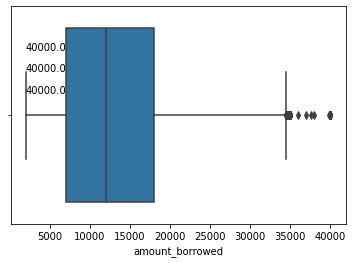

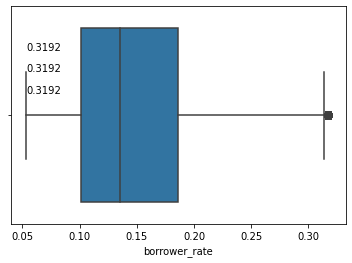

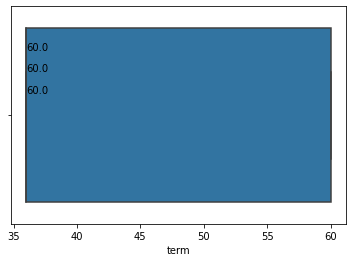

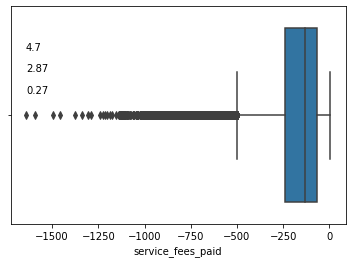

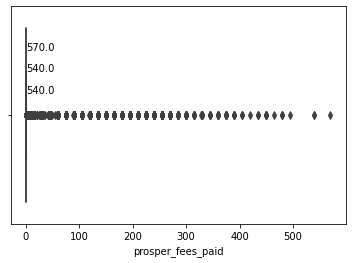

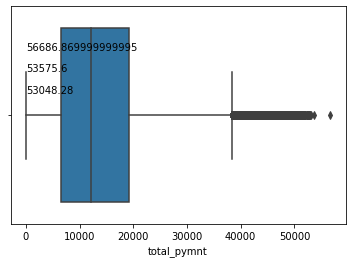

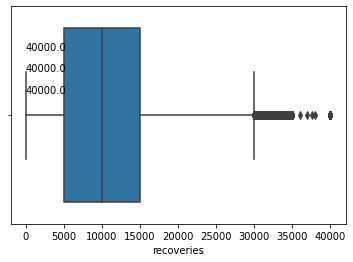

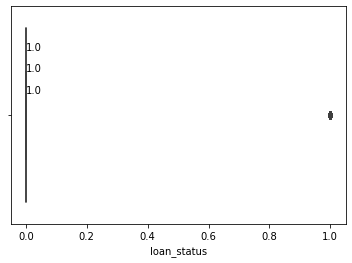

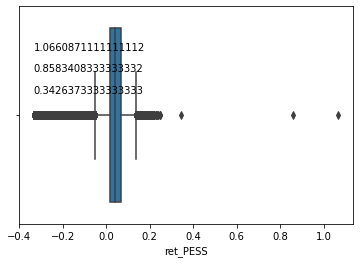

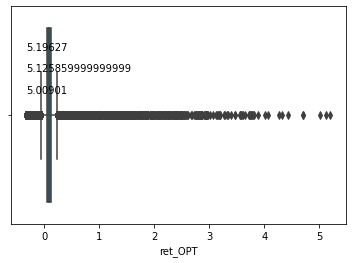

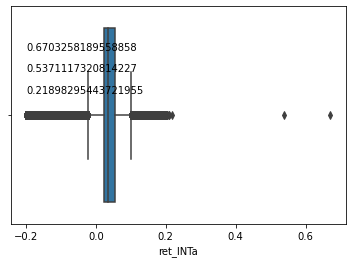

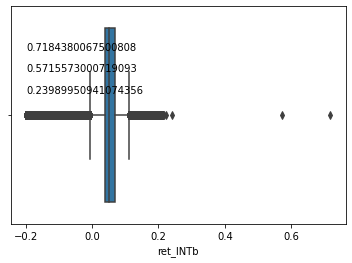

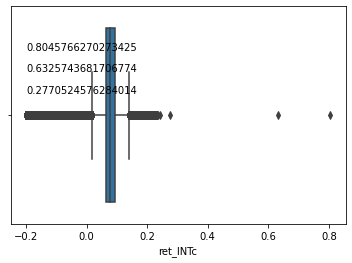

term
2 distinct values
36.0    548522
60.0    186734
Name: term, dtype: int64


co_borrower_application
1 distinct values
0.0    735256
Name: co_borrower_application, dtype: int64


grade
7 distinct values
C     180848
B     168944
A     146846
D      90010
AA     76296
E      52719
HR     19593
Name: grade, dtype: int64




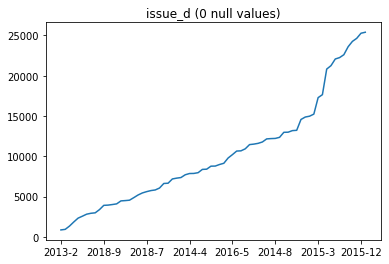

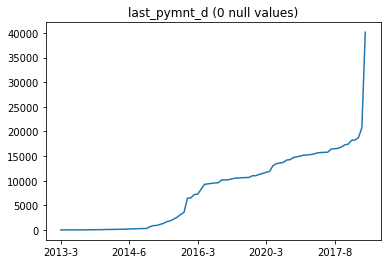

In [0]:
visualize_columns()

# Handle Outliers

All the outliers are found for the expected return calculated

In [0]:
#pessimistic

df = df[(df['ret_PESS'] < 0.3)]

#optimistic
df = df[df['ret_OPT'] < 2.75]

#reinvest

df = df[(df['ret_INTc'] < 0.3)]


In [0]:
df

,loan_number,amount_borrowed,borrower_rate,term,age_in_months,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,prosper_fees_paid,late_fees_paid,debt_sale_proceeds_received,next_payment_due_amount,co_borrower_application,total_pymnt,recoveries,issue_d,last_pymnt_d,loan_length,loan_status,grade,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
1,79656,4000.0,0.1559,36.0,88,0,0.0,-51.84,4000.0,808.28,0.0,0.00,0.0,0.00,0.0,4808.28,4000.0,2013-01-02,2015-04-02,26,0.0,B,0.067357,0.093263,0.049251,0.063118,0.087959
2,79665,17500.0,0.2398,60.0,88,0,0.0,-66.89,17500.0,1604.20,0.0,0.00,0.0,0.00,0.0,19104.20,17500.0,2013-01-02,2015-04-02,26,0.0,C,0.018334,0.042309,0.026120,0.038315,0.060096
3,79659,15000.0,0.1564,60.0,88,0,0.0,-298.07,15000.0,4661.84,0.0,0.00,0.0,361.91,0.0,19661.84,15000.0,2013-01-02,2016-08-02,42,0.0,A,0.062158,0.088797,0.068232,0.077655,0.094240
4,79668,10000.0,0.2118,60.0,88,0,0.0,-235.48,10000.0,4987.94,0.0,0.00,0.0,271.55,0.0,14987.94,10000.0,2013-01-02,2016-08-02,42,0.0,C,0.099759,0.142513,0.107311,0.119069,0.139884
5,79662,9500.0,0.1939,36.0,88,0,0.0,-98.53,9500.0,1910.21,15.0,35.02,0.0,0.00,0.0,11410.21,9500.0,2013-01-02,2015-04-02,26,0.0,C,0.067025,0.092804,0.049043,0.062894,0.087708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198746,1167680,10500.0,0.1628,60.0,17,0,0.0,-42.70,10500.0,646.63,0.0,0.00,0.0,0.00,0.0,11146.63,10500.0,2018-12-31,2019-06-30,5,0.0,C,0.012317,0.147801,0.024341,0.043642,0.079493
198748,1171231,9500.0,0.1003,36.0,17,0,0.0,-76.21,9500.0,711.10,15.0,0.00,0.0,0.00,0.0,10211.10,9500.0,2018-12-31,2019-11-30,10,0.0,A,0.024951,0.089823,0.026058,0.043748,0.076294
198750,1167848,7000.0,0.0904,36.0,17,0,0.0,-69.31,7000.0,582.61,0.0,0.00,0.0,0.00,0.0,7582.61,7000.0,2018-12-31,2020-02-11,13,0.0,A,0.027743,0.076828,0.027171,0.043905,0.074520
198751,1180476,8500.0,0.2204,36.0,17,0,0.0,-42.17,8500.0,864.68,0.0,0.00,0.0,0.00,0.0,9364.68,8500.0,2018-12-31,2019-07-03,6,0.0,C,0.033909,0.203454,0.032619,0.052297,0.088786


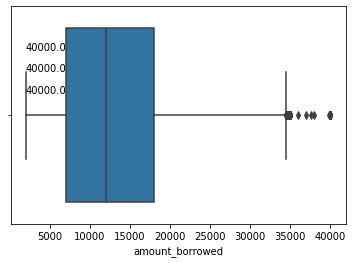

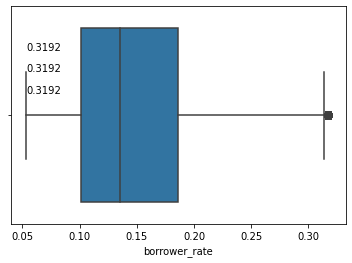

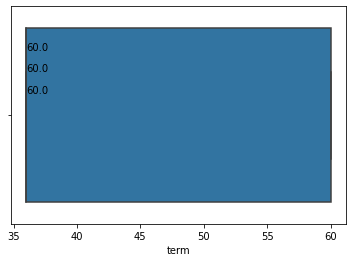

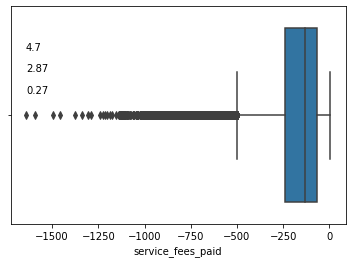

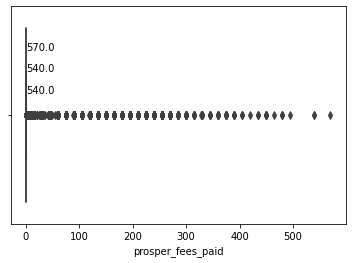

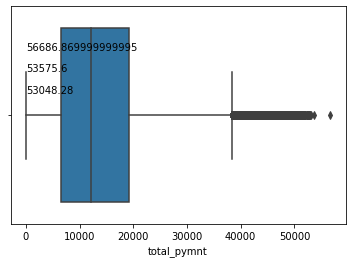

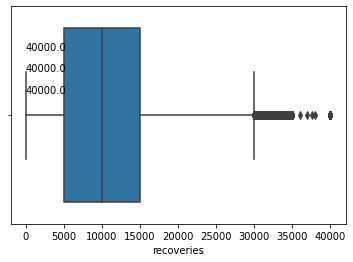

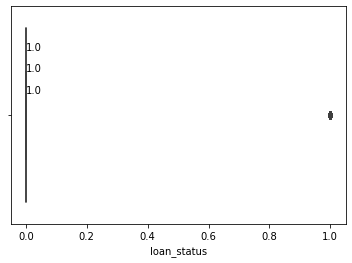

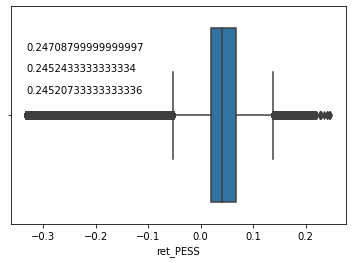

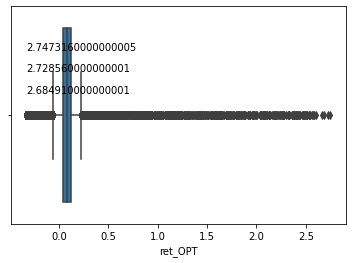

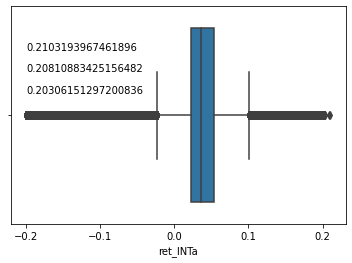

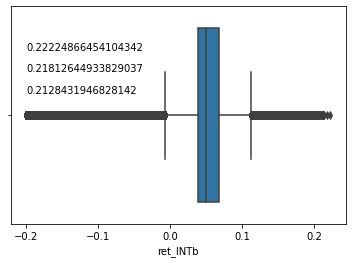

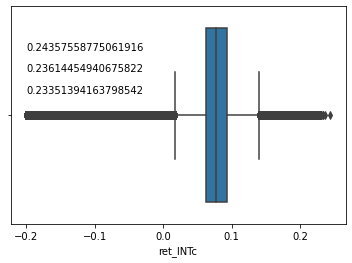

term
2 distinct values
36.0    548479
60.0    186704
Name: term, dtype: int64


co_borrower_application
1 distinct values
0.0    735183
Name: co_borrower_application, dtype: int64


grade
7 distinct values
C     180833
B     168940
A     146845
D      89983
AA     76296
E      52697
HR     19589
Name: grade, dtype: int64




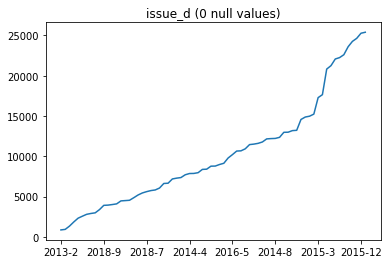

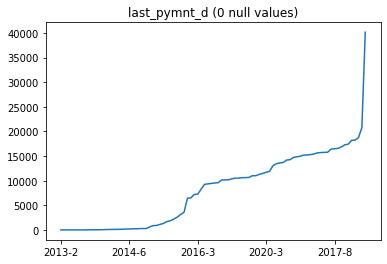

In [0]:
visualize_columns()

# Manage Data Imbalance between Completed and Default

In [0]:
df['loan_status'].value_counts()

0.0    624679
1.0    110504
Name: loan_status, dtype: int64

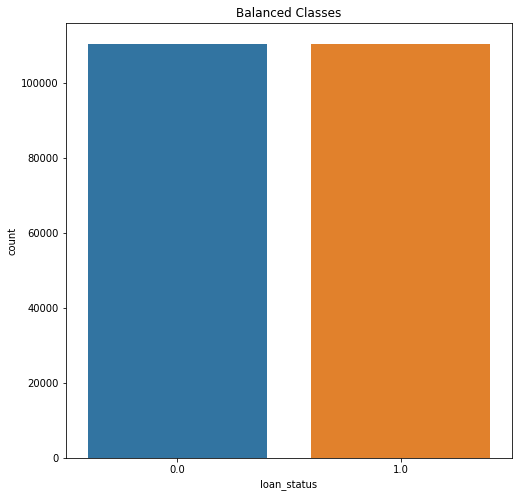

In [0]:
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
default_df = shuffled_df.loc[shuffled_df['loan_status'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
complete_df = shuffled_df.loc[shuffled_df['loan_status'] == 0].sample(n=110504,random_state=42)

# Concatenate both dataframes again
df = pd.concat([default_df, complete_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('loan_status', data=df)
plt.title('Balanced Classes')
plt.show()

# Data Exploration

In [0]:
perc_by_grade = (df["grade"].value_counts()*100/len(df)).sort_index()
default_by_grade = df.groupby("grade").apply(lambda x : (x.loan_status != 0).sum()*100/len(x) )
ret_by_grade_OPT = df.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = df.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = df.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = df.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
ret_by_grade_INTc = df.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
int_rate_by_grade = df.groupby("grade").apply(lambda x : np.mean(x.borrower_rate)*100)

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_PESS'] = ret_by_grade_PESS
combined['return_OPT'] = ret_by_grade_OPT
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
combined['return_INTc'] = ret_by_grade_INTc

combined

,grade,default,int_rate,return_PESS,return_OPT,return_INTa,return_INTb,return_INTc
A,16.375878,34.944187,9.538783,-2.474031,-0.878019,-0.910899,0.147415,2.054459
AA,7.315120,18.946001,6.812487,-0.541292,0.901011,0.408420,1.568575,3.660394
B,21.652157,45.740079,12.460648,-3.750521,-1.679114,-2.000569,-0.990740,0.833388
C,26.888167,56.344973,16.524345,-4.971645,-2.390153,-3.167542,-2.191823,-0.425022
D,15.023438,63.123814,21.864717,-6.024556,-2.782839,-4.024851,-3.049293,-1.277420
E,9.258488,65.457922,26.980508,-6.464774,-2.762397,-3.933130,-2.920515,-1.078863
HR,3.486752,65.792889,30.860243,-7.820892,-3.933467,-4.032661,-2.986616,-1.081351


# Save as Pickle

In [0]:
# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols))

# All numeric columns will be used as continuous features
continuous_features = list(set(float_cols) - set(["loan_status"]))

continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]


#pickle.dump([df, discrete_features, continuous_features, ret_cols], open('/content/drive/My Drive/ServiceAnalytics/mypickle_balanced.pickle', "wb"))

# Save as CSV

In [0]:
#df.to_csv('/content/drive/My Drive/ServiceAnalytics/cleaned_df_balanced.csv')